# 🧪 Free Fall with Noise: Modeling Motion Under Uncertainty

In this notebook, we simulate the vertical motion of a freely falling object and introduce controlled noise to the data. The goal is to explore how well we can recover physically meaningful parameters—like gravitational acceleration—from imperfect observations.

This experiment serves as a bridge between classical physics and modern machine learning, testing the robustness and interpretability of models under noisy conditions. It also lays the foundation for future work in parameter recovery, uncertainty quantification, and scientific storytelling through annotated notebooks.


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

## Creating data

In [2]:
start = 0 
end = 10
n_samples = 100
steps = (end - start)/n_samples
t = torch.arange(start, end, steps).unsqueeze(dim=1)

# Constants
a = 4.9
b = 20
c = 300

X = torch.cat([t, t**2], dim = 1)
y = -a*t**2 + b*t + c

## Instantiate The Model (5% Guassian Noise)

In [3]:
import sys
sys.path.append('../utils')
from free_fall_noise_experiment import FreeFallExperiment
model_mae = FreeFallExperiment(X = X, y= y, noise_level = 0.05, loss_fn= nn.L1Loss(), epochs = 10000, patience = 300, model_name = 'MAE_5_noise')
model_mse = FreeFallExperiment(X = X, y= y, noise_level = 0.05, loss_fn= nn.MSELoss(), epochs = 10000, patience = 300, model_name = 'MSE_5_noise')

### Results for MAE

In [4]:
model_mae.run()

Epoch: 0 | Train Loss: 0.533058226108551 | Test Loss: 0.526945948600769 
Epoch: 200 | Train Loss: 0.14042797684669495 | Test Loss: 0.4658520817756653 
Epoch: 400 | Train Loss: 0.1325305998325348 | Test Loss: 0.4102046489715576 
Epoch: 600 | Train Loss: 0.12662973999977112 | Test Loss: 0.32557058334350586 
Epoch: 800 | Train Loss: 0.12209866940975189 | Test Loss: 0.26472848653793335 
Epoch: 1000 | Train Loss: 0.11954186111688614 | Test Loss: 0.22726722061634064 
Epoch: 1200 | Train Loss: 0.11746136099100113 | Test Loss: 0.20468802750110626 
Epoch: 1400 | Train Loss: 0.1158306747674942 | Test Loss: 0.19161193072795868 
Epoch: 1600 | Train Loss: 0.11521059274673462 | Test Loss: 0.17806808650493622 
Epoch: 1800 | Train Loss: 0.11498955637216568 | Test Loss: 0.16386491060256958 
Epoch: 2000 | Train Loss: 0.11486054956912994 | Test Loss: 0.15895073115825653 
Epoch: 2200 | Train Loss: 0.11477375030517578 | Test Loss: 0.15626995265483856 
Epoch: 2400 | Train Loss: 0.11471054702997208 | Test Lo

### Results for MSE

In [5]:
model_mse.run()

Epoch: 0 | Train Loss: 0.33959561586380005 | Test Loss: 0.3243476450443268 
Epoch: 200 | Train Loss: 0.03420163318514824 | Test Loss: 0.23136520385742188 
Epoch: 400 | Train Loss: 0.03217180445790291 | Test Loss: 0.23193374276161194 
Epoch: 600 | Train Loss: 0.030556654557585716 | Test Loss: 0.20712149143218994 
Epoch: 800 | Train Loss: 0.02913517877459526 | Test Loss: 0.18313749134540558 
Epoch: 1000 | Train Loss: 0.027883034199476242 | Test Loss: 0.16185946762561798 
Epoch: 1200 | Train Loss: 0.026780012995004654 | Test Loss: 0.14312252402305603 
Epoch: 1400 | Train Loss: 0.025808393955230713 | Test Loss: 0.1266367882490158 
Epoch: 1600 | Train Loss: 0.02495250664651394 | Test Loss: 0.11213342100381851 
Epoch: 1800 | Train Loss: 0.024198567494750023 | Test Loss: 0.09937547147274017 
Epoch: 2000 | Train Loss: 0.023534435778856277 | Test Loss: 0.08815401792526245 
Epoch: 2200 | Train Loss: 0.02294940873980522 | Test Loss: 0.07828469574451447 
Epoch: 2400 | Train Loss: 0.022434076294302

### Visualizing The Loss Curves (MAE vs. MSE)

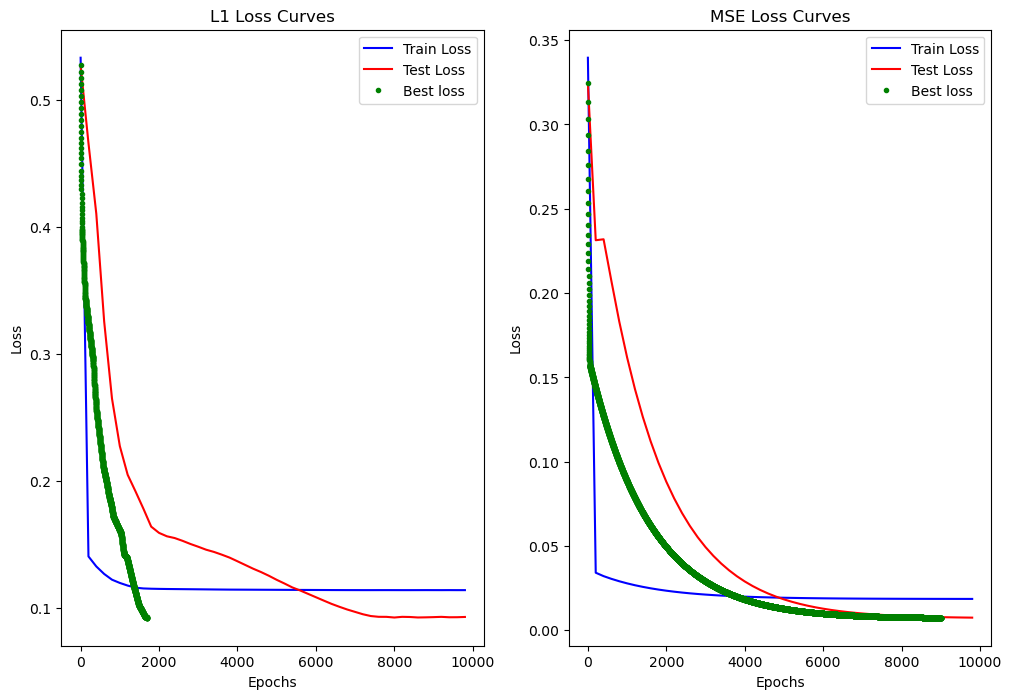

In [6]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
model_mae.plot_loss_curves()
plt.subplot(1,2,2)
model_mse.plot_loss_curves()

### Recoverd Parameters (MAE vs. MSE)

In [7]:
model_mae.recovered_parameters()
model_mse.recovered_parameters()

Recovered Physical Parameters (L1 Loss):
a = 4.60, b = 18.00, c = 300.73
Recovered Physical Parameters (MSE Loss):
a = 4.80, b = 19.08, c = 302.33


### Visualizing the Predictions (MAE vs MSE)

Text(0.5, 1.0, 'Predicted Free Fall Model (MSE)')

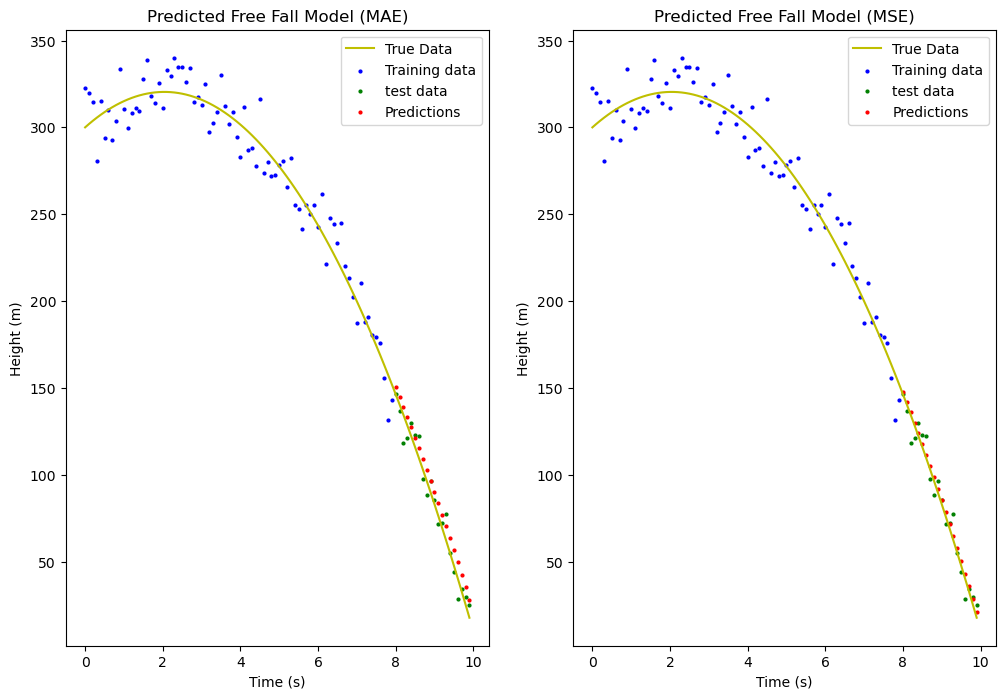

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(t,y, c='y', label='True Data')
model_mae.plot_results()
plt.title('Predicted Free Fall Model (MAE)')
plt.subplot(1,2,2)
plt.plot(t,y, c='y', label='True Data')
model_mse.plot_results()
plt.title('Predicted Free Fall Model (MSE)')

## Instantiate The Model (10% Guassian Noise)

In [9]:
import sys
sys.path.append('../utils')
from free_fall_noise_experiment import FreeFallExperiment
model_mae = FreeFallExperiment(X = X, y= y, noise_level = 0.10, loss_fn= nn.L1Loss(), epochs = 10000, patience = 300, model_name = 'MAE_10_noise')
model_mse = FreeFallExperiment(X = X, y= y, noise_level = 0.10, loss_fn= nn.MSELoss(), epochs = 10000, patience = 300, model_name = 'MSE_10_noise')

### Results for MAE

In [10]:
model_mae.run()

Epoch: 0 | Train Loss: 0.5374982953071594 | Test Loss: 0.48848479986190796 
Epoch: 200 | Train Loss: 0.23026414215564728 | Test Loss: 0.4081713557243347 
Epoch: 400 | Train Loss: 0.22819682955741882 | Test Loss: 0.3946821391582489 
Epoch: 600 | Train Loss: 0.22647595405578613 | Test Loss: 0.3824201822280884 
Epoch: 800 | Train Loss: 0.22553114593029022 | Test Loss: 0.36997655034065247 
Epoch: 1000 | Train Loss: 0.22490963339805603 | Test Loss: 0.3563210368156433 
Epoch: 1200 | Train Loss: 0.22446517646312714 | Test Loss: 0.33699923753738403 
Epoch: 1400 | Train Loss: 0.2243022471666336 | Test Loss: 0.3254414200782776 
Epoch: 1600 | Train Loss: 0.22415754199028015 | Test Loss: 0.31403177976608276 
Epoch: 1800 | Train Loss: 0.22403328120708466 | Test Loss: 0.3101797103881836 
Epoch: 2000 | Train Loss: 0.22391411662101746 | Test Loss: 0.3088349997997284 
Epoch: 2200 | Train Loss: 0.2238357812166214 | Test Loss: 0.306304395198822 
Epoch: 2400 | Train Loss: 0.22377367317676544 | Test Loss: 

### Results for MSE

In [11]:
model_mse.run()

Epoch: 0 | Train Loss: 0.37683218717575073 | Test Loss: 0.29525336623191833 
Epoch: 200 | Train Loss: 0.0852288231253624 | Test Loss: 0.22645679116249084 
Epoch: 400 | Train Loss: 0.08333457261323929 | Test Loss: 0.22861042618751526 
Epoch: 600 | Train Loss: 0.0818425640463829 | Test Loss: 0.2061983048915863 
Epoch: 800 | Train Loss: 0.08052958548069 | Test Loss: 0.18442986905574799 
Epoch: 1000 | Train Loss: 0.07937299460172653 | Test Loss: 0.16512906551361084 
Epoch: 1200 | Train Loss: 0.07835417985916138 | Test Loss: 0.14815479516983032 
Epoch: 1400 | Train Loss: 0.07745672762393951 | Test Loss: 0.13323922455310822 
Epoch: 1600 | Train Loss: 0.07666616141796112 | Test Loss: 0.12013550102710724 
Epoch: 1800 | Train Loss: 0.07596977800130844 | Test Loss: 0.10862568765878677 
Epoch: 2000 | Train Loss: 0.07535634934902191 | Test Loss: 0.09851822257041931 
Epoch: 2200 | Train Loss: 0.07481597363948822 | Test Loss: 0.0896434411406517 
Epoch: 2400 | Train Loss: 0.07433996349573135 | Test L

### Visualizing the Loss Curves (MAE vs MSE)

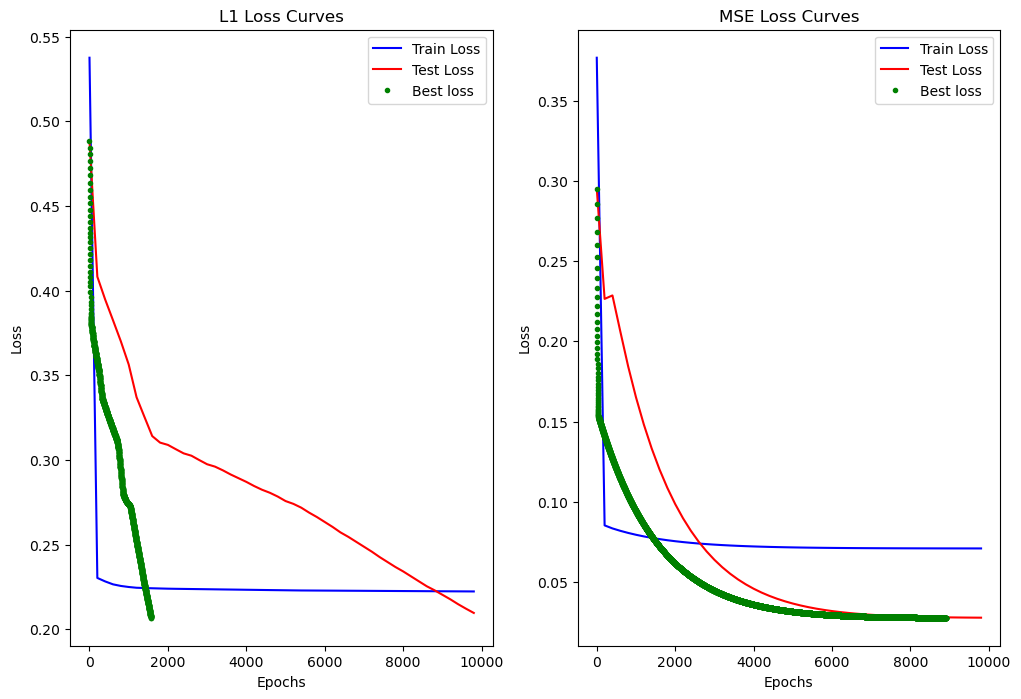

In [12]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
model_mae.plot_loss_curves()
plt.subplot(1,2,2)
model_mse.plot_loss_curves()

### Recovered Parameters (MAE vs MSE)

In [13]:
model_mae.recovered_parameters()
model_mse.recovered_parameters()

Recovered Physical Parameters (L1 Loss):
a = 4.13, b = 14.68, c = 303.33
Recovered Physical Parameters (MSE Loss):
a = 4.81, b = 19.02, c = 303.47


### Visualizing the Predictions (MAE vs MSE)

Text(0.5, 1.0, 'Predicted Free Fall Model (MSE)')

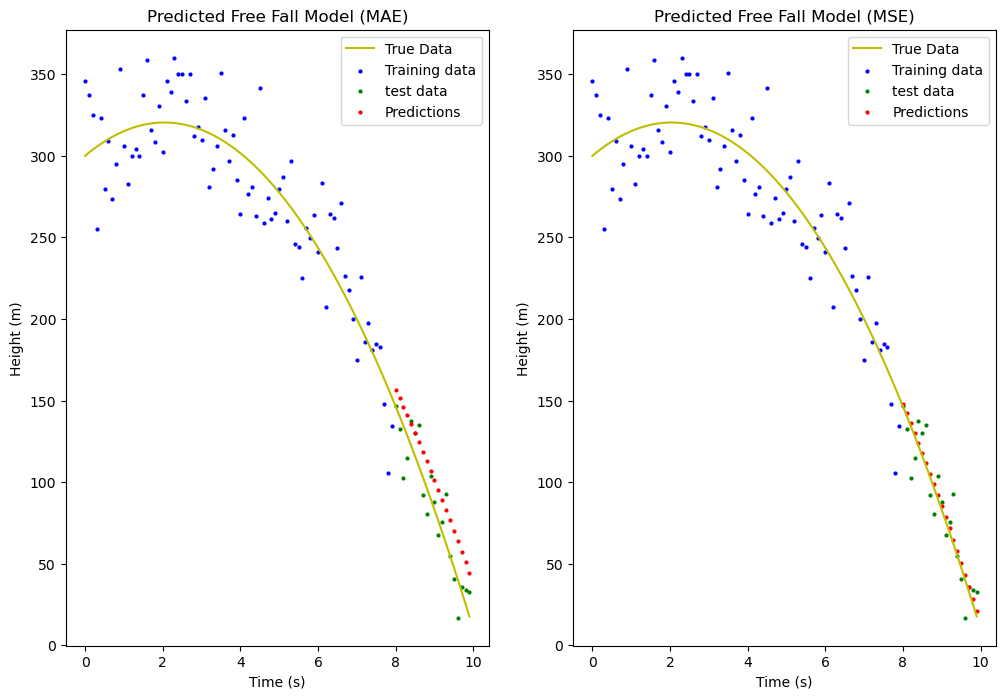

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(t,y, c='y', label='True Data')
model_mae.plot_results()
plt.title('Predicted Free Fall Model (MAE)')
plt.subplot(1,2,2)
plt.plot(t,y, c='y', label='True Data')
model_mse.plot_results()
plt.title('Predicted Free Fall Model (MSE)')

## Instantiate The Model (20% Guassian Noise)

In [15]:
import sys
sys.path.append('../utils')
from free_fall_noise_experiment import FreeFallExperiment
model_mae = FreeFallExperiment(X = X, y= y, noise_level = 0.20, loss_fn= nn.L1Loss(), epochs = 10000, patience = 300, model_name = 'MAE_10_noise')
model_mse = FreeFallExperiment(X = X, y= y, noise_level = 0.20, loss_fn= nn.MSELoss(), epochs = 10000, patience = 300, model_name = 'MSE_10_noise')

### Results for MAE

In [16]:
model_mae.run()

Epoch: 0 | Train Loss: 0.5374982953071594 | Test Loss: 0.48848479986190796 
Epoch: 200 | Train Loss: 0.23026414215564728 | Test Loss: 0.4081713557243347 
Epoch: 400 | Train Loss: 0.22819682955741882 | Test Loss: 0.3946821391582489 
Epoch: 600 | Train Loss: 0.22647595405578613 | Test Loss: 0.3824201822280884 
Epoch: 800 | Train Loss: 0.22553114593029022 | Test Loss: 0.36997655034065247 
Epoch: 1000 | Train Loss: 0.22490963339805603 | Test Loss: 0.3563210368156433 
Epoch: 1200 | Train Loss: 0.22446517646312714 | Test Loss: 0.33699923753738403 
Epoch: 1400 | Train Loss: 0.2243022471666336 | Test Loss: 0.3254414200782776 
Epoch: 1600 | Train Loss: 0.22415754199028015 | Test Loss: 0.31403177976608276 
Epoch: 1800 | Train Loss: 0.22403328120708466 | Test Loss: 0.3101797103881836 
Epoch: 2000 | Train Loss: 0.22391411662101746 | Test Loss: 0.3088349997997284 
Epoch: 2200 | Train Loss: 0.2238357812166214 | Test Loss: 0.306304395198822 
Epoch: 2400 | Train Loss: 0.22377367317676544 | Test Loss: 

### Results for MSE

In [17]:
model_mse.run()

Epoch: 0 | Train Loss: 0.37683218717575073 | Test Loss: 0.29525336623191833 
Epoch: 200 | Train Loss: 0.0852288231253624 | Test Loss: 0.22645679116249084 
Epoch: 400 | Train Loss: 0.08333457261323929 | Test Loss: 0.22861042618751526 
Epoch: 600 | Train Loss: 0.0818425640463829 | Test Loss: 0.2061983048915863 
Epoch: 800 | Train Loss: 0.08052958548069 | Test Loss: 0.18442986905574799 
Epoch: 1000 | Train Loss: 0.07937299460172653 | Test Loss: 0.16512906551361084 
Epoch: 1200 | Train Loss: 0.07835417985916138 | Test Loss: 0.14815479516983032 
Epoch: 1400 | Train Loss: 0.07745672762393951 | Test Loss: 0.13323922455310822 
Epoch: 1600 | Train Loss: 0.07666616141796112 | Test Loss: 0.12013550102710724 
Epoch: 1800 | Train Loss: 0.07596977800130844 | Test Loss: 0.10862568765878677 
Epoch: 2000 | Train Loss: 0.07535634934902191 | Test Loss: 0.09851822257041931 
Epoch: 2200 | Train Loss: 0.07481597363948822 | Test Loss: 0.0896434411406517 
Epoch: 2400 | Train Loss: 0.07433996349573135 | Test L

### Visualizing the Loss Curves (MAE vs MSE)

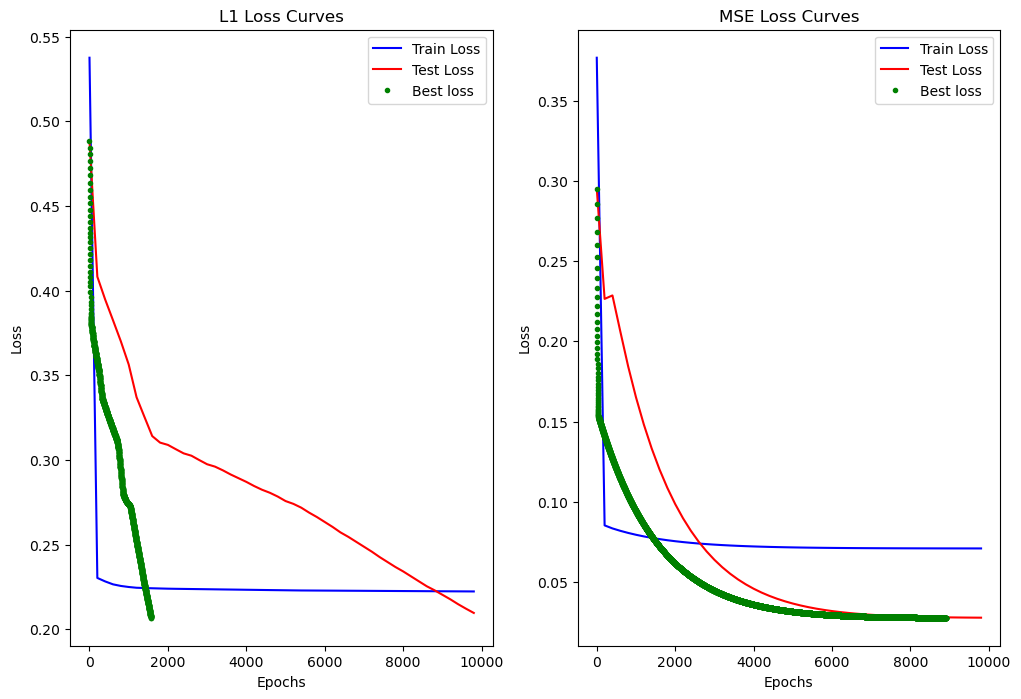

In [18]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
model_mae.plot_loss_curves()
plt.subplot(1,2,2)
model_mse.plot_loss_curves()

### Recovered Parameters (MAE vs MSE)

In [19]:
model_mae.recovered_parameters()
model_mse.recovered_parameters()

Recovered Physical Parameters (L1 Loss):
a = 4.13, b = 14.68, c = 303.33
Recovered Physical Parameters (MSE Loss):
a = 4.81, b = 19.02, c = 303.47


### Visualizing the Predictions (MAE vs MSE)

Text(0.5, 1.0, 'Predicted Free Fall Model (MSE)')

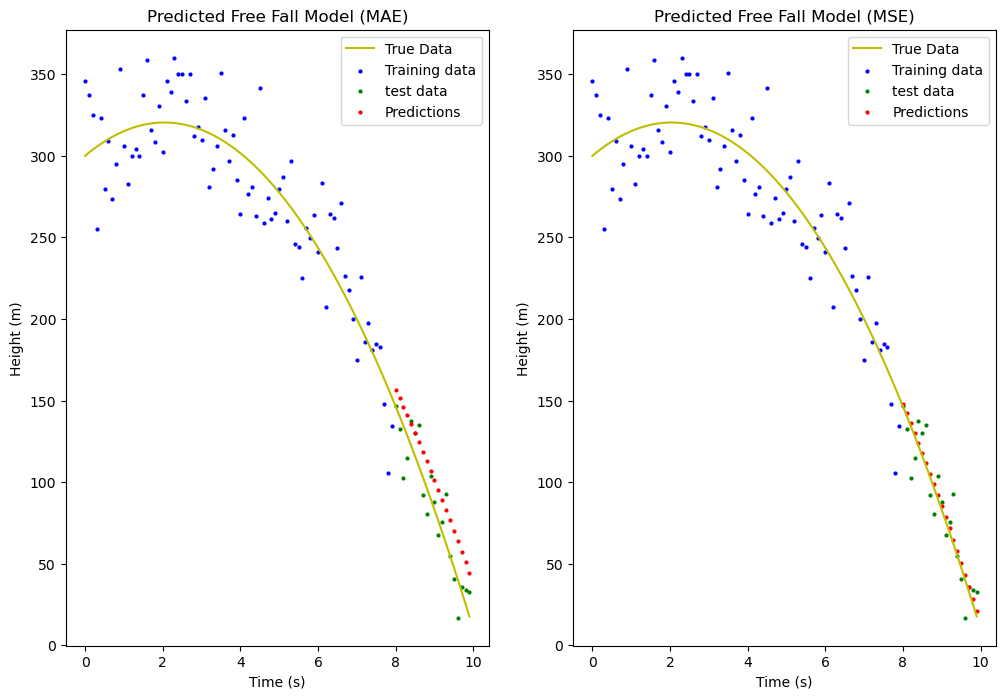

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(t,y, c='y', label='True Data')
model_mae.plot_results()
plt.title('Predicted Free Fall Model (MAE)')
plt.subplot(1,2,2)
plt.plot(t,y, c='y', label='True Data')
model_mse.plot_results()
plt.title('Predicted Free Fall Model (MSE)')

## 📊 Reflections on Loss Functions: MAE vs. MSE

Across all three noise levels (5%, 10%, 20%), **Mean Squared Error (MSE)** consistently outperformed **Mean Absolute Error (MAE)** in recovering physically meaningful parameters. This outcome aligns with both theoretical expectations and prior empirical observations:

### 🔍 Why MSE Performs Better in This Context

- **Sensitivity to Gaussian Noise**:  
  MSE is statistically optimal under Gaussian noise assumptions, which matches the noise injected in our experiments. It penalizes larger errors more heavily, making it more responsive to the distribution's variance.

- **Convergence Efficiency**:  
  MAE's gradient is less stable near zero, leading to slower convergence and higher computational cost. While MAE may eventually reach comparable minima, the training time and instability make it less practical for this setup.

- **Outlier Robustness Tradeoff**:  
  MAE is known to be more robust to single outliers, but our noise was uniformly Gaussian—not dominated by extreme values. Thus, MAE’s robustness didn’t translate into better parameter recovery here.

### 🧠 Final Thoughts

While MAE might shine in datasets with sporadic outliers or non-Gaussian noise, in this controlled setting MSE offers a better balance of accuracy and efficiency. **Future experiments could explore hybrid loss functions or adaptive weighting to combine the strengths of both.**
